# Static maps

## Static maps in geopandas

We have already plotted basic static maps using geopandas during the previous weeks of this course. Remember that when using the [plot() method in geopandas](http://geopandas.org/mapping.html#mapping-tools), we are actually using the tools available from [matplotlib pyplot](https://matplotlib.org/api/pyplot_api.html#pyplot). 

Let's refresh our memory about the basics of plotting maps by creating a static accessibility map with roads and metro line on it (three layers on top of each other in the same figure). Before plotting the layers, we need to check that they are in the same coordinate reference system.

As usual, we start by importing the useful modules and reading in the input files:

In [1]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
from pathlib import Path
import contextily as ctx

# Filepaths
data_dir = Path("../data")
grid_fp = data_dir / "TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = data_dir / "roads.shp"
metro_fp = data_dir / "metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

Let's check the coordinate reference systems (crs) of the input files. 

In [2]:
# Check the crs of each layer
print(roads.crs)
print(metro.crs)
print(grid.crs)

epsg:2392
epsg:2392
epsg:3067


Roads and the metro are in an old Finnish crs (EPSG:2392), while the grid is in ETRS89 / TM35FIN (EPSG:3067):

In [3]:
# Check CRS names
print("Roads crs:", CRS(roads.crs).name)
print("Metro crs:", CRS(metro.crs).name)
print("Grid crs: ", CRS(grid.crs).name)

Roads crs: KKJ / Finland zone 2
Metro crs: KKJ / Finland zone 2
Grid crs:  ETRS89 / TM35FIN(E,N)


Let's re-project geometries to ETRS89 / TM35FIN based on the grid crs:

In [4]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

Now the layers should be in the same crs

In [5]:
roads.crs == metro.crs == grid.crs

True

Once the data are in the same projection, we can plot them on a map.

<div class="alert alert-info">

**Check your understanding**

- Make a visualization using the `plot()` -function in Geopandas
- plot first the grid using "quantiles" classification scheme
- then add roads and metro in the same plot

</div>

Plotting options for the polygon: 

- Define the classification scheme using the `scheme` parameter
- Change the colormap using the `cmap` parameter. See [colormap options from matplotlib documentation](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib).
- You can add a little bit of transparency for the grid using the `alpha` parameter (ranges from 0 to 1 where 0 is fully transparent)

Plotting options fo the lines:

 - adjust color using `color` parameter. See [color options from matplotlib pyplot documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors).
 - change `linewidth` if needed
 
For better control of the figure and axes, use the plt.subplots function before plotting the layers. See more info in [matplotlib documentation](https://matplotlib.org/3.3.3/gallery/subplots_axes_and_figures/subplots_demo.html#a-figure-with-just-one-subplot).

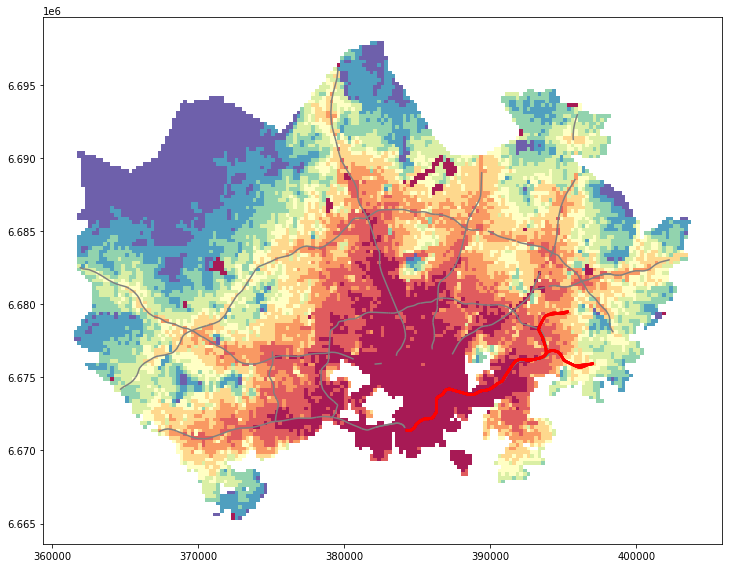

In [6]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=ax,
    column="car_r_t",
    linewidth=0.03,
    cmap="Spectral",
    scheme="quantiles",
    k=9,
    alpha=0.9,
)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

## Adding a legend

It is possible to enable legend for a geopandas plot by setting `legend=True` in the plotting parameters.
If plotting the figure without a classification scheme you get a color bar as the legend item and it is easy to add a label for the legend using `legend_kwds`. You can read more about creating a legend via geopandas [in here](https://geopandas.org/mapping.html#creating-a-legend).

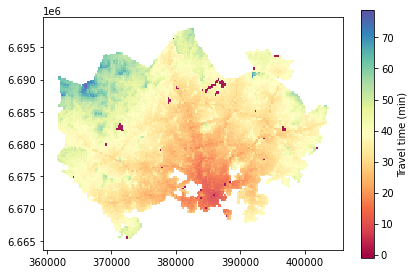

In [7]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=ax,
    column="car_r_t",
    linewidth=0.03,
    cmap="Spectral",
    alpha=0.9,
    legend=True,
    legend_kwds={"label": "Travel time (min)"},
)

# ax.get_legend().set_bbox_to_anchor(8)
# ax.get_legend().set_title("Legend title")

# Remove the empty white-space around the axes
plt.tight_layout()

If plotting a map using a classification scheme, we get a different kind of ledend that shows the class values. In this case, we can control the position and title of the legend using matplotlib tools. We first need to access the [Legend object](https://matplotlib.org/3.3.2/api/legend_api.html#matplotlib.legend.Legend) and then change it's properties.

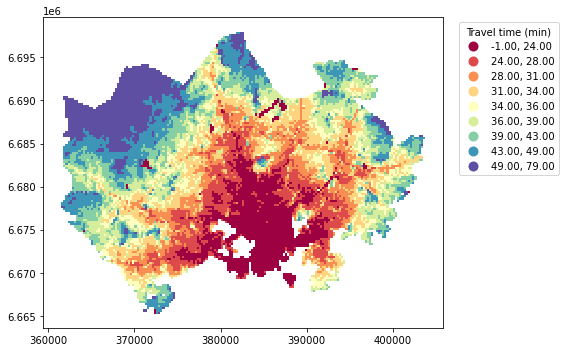

In [8]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(10, 5))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=ax,
    column="car_r_t",
    linewidth=0.03,
    cmap="Spectral",
    scheme="quantiles",
    k=9,
    legend=True,
)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.3, 1))
ax.get_legend().set_title("Travel time (min)")

# Remove the empty white-space around the axes
plt.tight_layout()

You can read more info about adjusting legends in the matplotlig [legend guide](https://matplotlib.org/tutorials/intermediate/legend_guide.html).

## Adding basemap from external source

It is often useful to add a basemap to your visualization that shows e.g. streets, placenames and other contextual information. This can be done easily by using ready-made background map tiles from different providers such as [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Tiles) or [Stamen Design](http://maps.stamen.com). A Python library called [contextily](https://github.com/darribas/contextily) is a handy package that can be used to fetch geospatial raster files and add them to your maps. Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/), hence **it is often necessary to reproject all the spatial data into** [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) before visualizing the data.

In this tutorial, we will see how to add a basemap underneath our previous visualization. 
Check the input crs:

In [9]:
print(grid.crs)

epsg:3067


Reproject the layer to ESPG 3857 projection (Web Mercator):

In [10]:
# Reproject to EPSG 3857
data = grid.to_crs(epsg=3857)
print(data.crs)

epsg:3857


Now the crs is `epsg:3857`. Also the coordinate values in the `geometry` column have changed:

In [11]:
data.head(2)

car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   

                                            geometry  
0  POLYGON ((2767221.646 8489079.101, 2766716.966...  
1  POLYGON ((2767726.329 8489095.521, 2767221.646...

Next, we can plot our data using geopandas and add a basemap for our plot by using a function called `add_basemap()` from contextily:

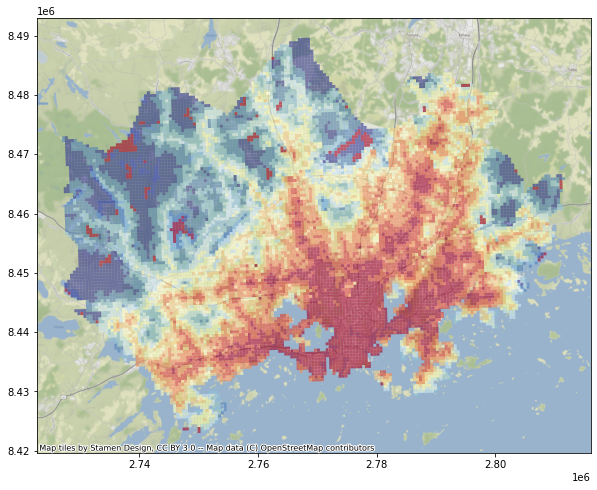

In [12]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
data.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=9,
    alpha=0.6,
)

# Add basemap
ctx.add_basemap(ax)

As we can see, now the map has a background map that is by default using the Stamen Terrain background from [Stamen Design](http://maps.stamen.com/#terrain). 

There are also various other possible data sources and styles for background maps. 

Contextily's `tile_providers` contain a list of providers and styles that can be used to control the appearence of your background map:

In [13]:
dir(ctx.providers)

['AzureMaps',
 'BasemapAT',
 'CartoDB',
 'CyclOSM',
 'Esri',
 'FreeMapSK',
 'Gaode',
 'GeoportailFrance',
 'HERE',
 'HEREv3',
 'HikeBike',
 'Hydda',
 'Jawg',
 'JusticeMap',
 'MapBox',
 'MapTiler',
 'MtbMap',
 'NASAGIBS',
 'NLS',
 'OPNVKarte',
 'OneMapSG',
 'OpenAIP',
 'OpenFireMap',
 'OpenRailwayMap',
 'OpenSeaMap',
 'OpenSnowMap',
 'OpenStreetMap',
 'OpenTopoMap',
 'OpenWeatherMap',
 'SafeCast',
 'Stadia',
 'Stamen',
 'Strava',
 'Thunderforest',
 'TomTom',
 'USGS',
 'WaymarkedTrails',
 'nlmaps']

There are multiple style options for most of these providers, for example: 

In [14]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

It is possible to change the tile provider using the `source` -parameter in `add_basemap()` function. Let's see how we can change the bacground map as the basic OpenStreetMap background:

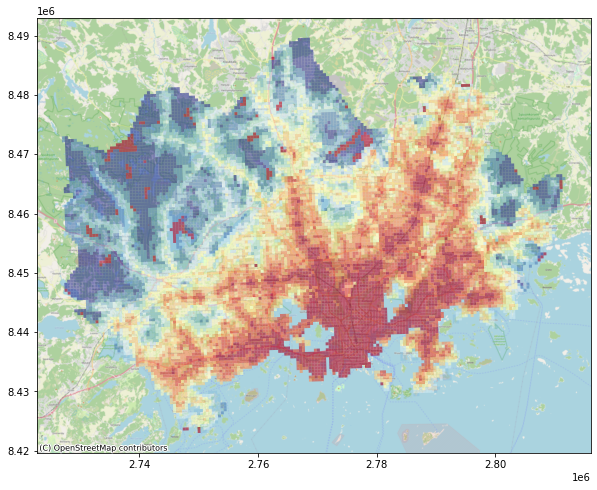

In [15]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
data.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=9,
    alpha=0.6,
)

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

 Let's take a subset of our data to see a bit better the background map characteristics:

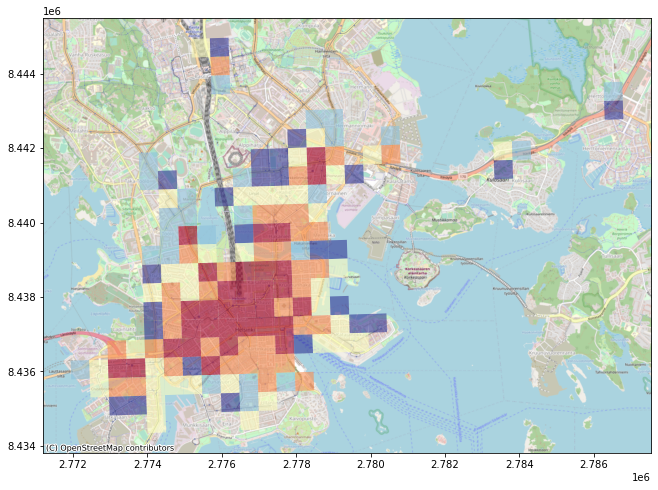

In [16]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# Subset the data to seel only grid squares near the destination
subset = data.loc[(data["pt_r_t"] >= 0) & (data["pt_r_t"] <= 15)]

# Plot the data from subset
subset.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=5,
    alpha=0.6,
)

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

As we can see now our map has much more details in it as the zoom level of the background map is larger. By default `contextily` sets the zoom level automatically but it is possible to also control that manually using parameter `zoom`. The zoom level is by default specified as `auto` but you can control that by passing in [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have).

- Let's reduce the level of detail from our map by passing `zoom=11`:


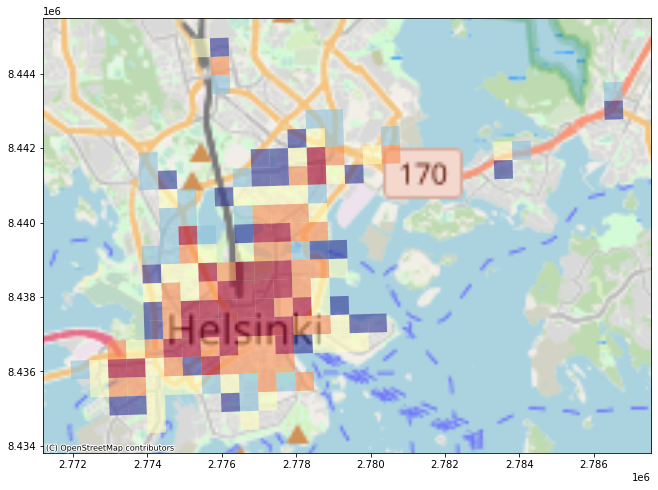

In [17]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data from subset
subset.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=5,
    alpha=0.6,
)

# Add basemap with `OSM_A` style using zoom level of 11
ctx.add_basemap(ax, zoom=11, source=ctx.providers.OpenStreetMap.Mapnik)

As we can see, the map has now less detail (a bit too blurry for such a small area).

We can also use `ax.set_xlim()` and `ax.set_ylim()` -parameters to crop our map without altering the data. The parameters takes as input the coordinates for minimum and maximum on both axis (x and y). We can also change / remove the contribution text by using parameter `attribution`

Let's add details about the data source, plot the original data, and crop the map:

In [18]:
credits = "Travel time data by Tenkanen & Toivonen (2020), Map Data © OpenStreetMap contributors"

(8430000.0, 8470000.0)

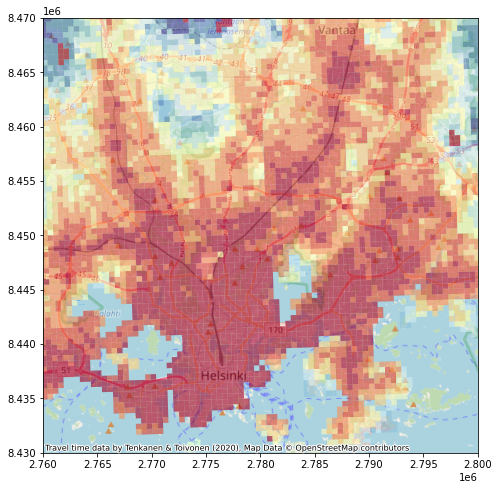

In [19]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
data.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=9,
    alpha=0.6,
)

# Add basemap with `OSM_A` style using zoom level of 11
# Modify the attribution
ctx.add_basemap(
    ax, zoom=11, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik
)

# Crop the figure
ax.set_xlim(2760000, 2800000)
ax.set_ylim(8430000, 8470000)

It is also possible to use many other map tiles from different [Tile Map Services](https://en.m.wikipedia.org/wiki/Tile_Map_Service) as the background map. A good list of different available sources can be found from [here](http://leaflet-extras.github.io/leaflet-providers/preview/). When using map tiles from different sources, it is necessary to parse a url address to the tile provider following a format defined by the provider. 

Next, we will see how to use map tiles provided by CartoDB. To do that we need to parse the url address following their [definition](https://github.com/CartoDB/basemap-styles#1-web-raster-basemaps) `'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'` where:

 - {s}: one of the available subdomains, either [a,b,c,d]
 - {z} : Zoom level. We support from 0 to 20 zoom levels in OSM tiling system.
 - {x},{y}: Tile coordinates in OSM tiling system
 - {scale}: OPTIONAL "@2x" for double resolution tiles
 - {style}: Map style, possible value is one of:
 
    - light_all,
    - dark_all,
    - light_nolabels,
    - light_only_labels,
    - dark_nolabels,
    - dark_only_labels,
    - rastertiles/voyager,
    - rastertiles/voyager_nolabels,
    - rastertiles/voyager_only_labels,
    - rastertiles/voyager_labels_under
    
- We will use this information to parse the parameters in a way that contextily wants them:

(8435000.0, 8442500.0)

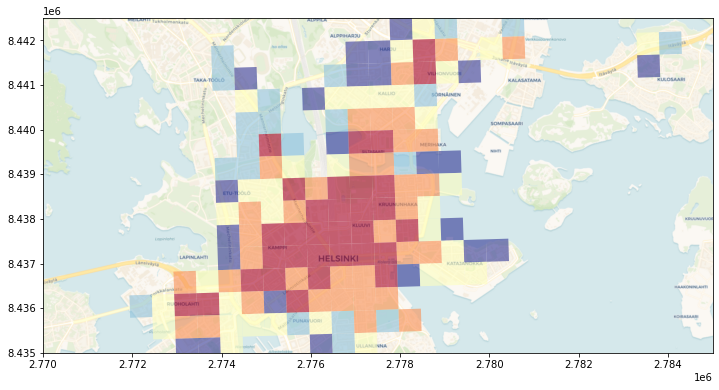

In [20]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'
# Specify the style to use
style = "rastertiles/voyager"
cartodb_url = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png" % style

# Plot the data from subset
subset.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=5,
    alpha=0.6,
)

# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, zoom=14, attribution="", source=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

As we can see now we have yet again different kind of background map, now coming from CartoDB. 
Let's make a minor modification and change the style from `"rastertiles/voyager"` to `"dark_all"`:


(8435000.0, 8442500.0)

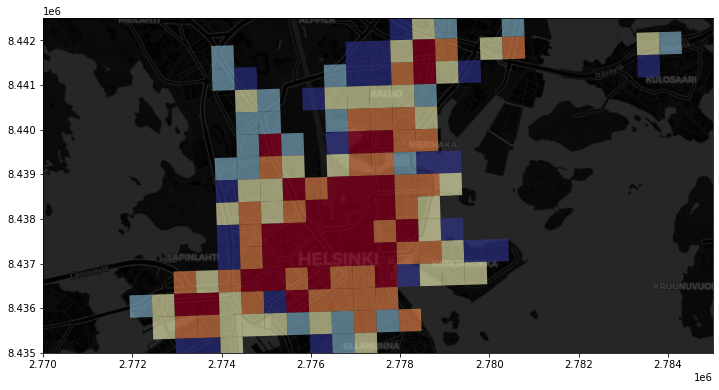

In [21]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
# Specify the style to use
style = "dark_all"
cartodb_url = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png" % style

# Plot the data from subset
subset.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=5,
    alpha=0.6,
)

# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, zoom=13, attribution="", source=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

Great! Now we have dark background map fetched from CartoDB. In a similar manner, you can use any map tiles from various other tile providers such as the ones listed in [leaflet-providers](http://leaflet-extras.github.io/leaflet-providers/preview/).

## Data reclassification

Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria. We could, for example, classify information based on travel times and housing prices using these criteria:

```
1. if travel time to my work is less than 30 minutes

    AND

    2. the rent of the apartment is less than 1000 € per month

    ------------------------------------------------------

    IF TRUE: ==> I go to view it and try to rent the apartment
    IF NOT TRUE: ==> I continue looking for something else
```

In this tutorial, we will:

1. Use classification schemes from the PySAL [mapclassify library](https://pysal.org/mapclassify/) to classify travel times into multiple classes.

2. Create a custom classifier to classify travel times and distances in order to find out good locations to buy an apartment with these conditions:
   - good public transport accessibility to city center
   - bit further away from city center where the prices are presumably lower


## Common classifiers

### Classification schemes for thematic maps

[PySAL](https://pysal.org/) -module is an extensive Python library for spatial analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data. Available map classifiers in [pysal's mapclassify -module](https://github.com/pysal/mapclassify):

 - Box_Plot
 - Equal_Interval
 - Fisher_Jenks
 - Fisher_Jenks_Sampled
 - HeadTail_Breaks
 - Jenks_Caspall
 - Jenks_Caspall_Forced
 - Jenks_Caspall_Sampled
 - Max_P_Classifier
 - Maximum_Breaks
 - Natural_Breaks
 - Quantiles
 - Percentiles
 - Std_Mean
 - User_Defined

- First, we need to read our Travel Time data from Helsinki:
<!-- #endregion -->

In [42]:
import geopandas as gpd


# Read the GeoJSON file similarly as Shapefile
acc = data.copy()

# Let's see what we have
acc.head()

car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   
2    30133       50    31872       56  5785642   32940     121      146   
3    32690       54    34429       60  5785643   33233     125      150   
4    31872       42    31834       48  5787544   32127     109      126   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   
2   32940     113      133  5975375   29626     423   
3   33233     117      144  5975375   29919     427   
4   32127     101      121  5975375   31674     452   

                                            geometry  
0  POLYGON ((2767221.646 8489079.101, 2766716.966...  
1  POLYGON ((2767726.329 8489095.521, 2767221.646...  
2  POLYGON ((2768231.014 8489111.905, 2767726.329...  
3  POLYGON ((2768735.702 8489128.255, 2768231.014...  
4  POLYGON ((2765724.126 8488524.148, 2765219.488...

As we can see, there are plenty of different variables (see [from here the description](http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015) for all attributes) but what we are interested in are columns called `pt_r_tt` which is telling the time in minutes that it takes to reach city center from different parts of the city, and `walk_d` that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

**The NoData values are presented with value -1**. 

- Thus we need to remove the No Data values first.


In [43]:
# Include only data that is above or equal to 0
acc = acc.loc[acc["pt_r_tt"] >= 0]

- Let's plot the data and see how it looks like
- `cmap` parameter defines the color map. Read more about [choosing colormaps in matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- `scheme` option scales the colors according to a classification scheme (requires `mapclassify` module to be installed):

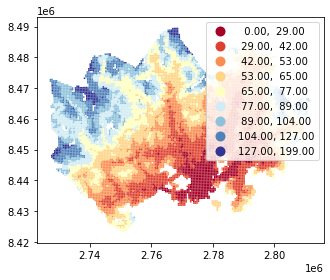

In [44]:
import matplotlib.pyplot as plt

# Plot using 9 classes and classify the values using "Natural Breaks" classification
acc.plot(
    column="pt_r_tt",
    scheme="Natural_Breaks",
    k=9,
    cmap="RdYlBu",
    linewidth=0,
    legend=True,
)

# Use tight layout
plt.tight_layout()

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of "good" accessibility also in some other areas (where the color is red).

- Let's also make a plot about walking distances:

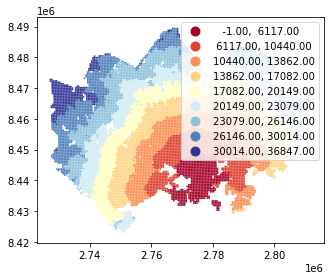

In [45]:
# Plot walking distance
acc.plot(
    column="walk_d",
    scheme="Natural_Breaks",
    k=9,
    cmap="RdYlBu",
    linewidth=0,
    legend=True,
)

# Use tight layour
plt.tight_layout()

Okay, from here we can see that the walking distances (along road network) reminds more or less Euclidian distances. 

### Applying classifiers to data

As mentioned, the `scheme` option defines the classification scheme using `pysal/mapclassify`. Let's have a closer look at how these classifiers work.

In [46]:
import mapclassify

- Natural Breaks

In [47]:
mapclassify.NaturalBreaks(y=acc["pt_r_tt"], k=9)

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  30.00] |   837
( 30.00,  43.00] |  2361
( 43.00,  54.00] |  2453
( 54.00,  65.00] |  2088
( 65.00,  78.00] |  1761
( 78.00,  92.00] |  1694
( 92.00, 108.00] |  1087
(108.00, 129.00] |   557
(129.00, 199.00] |   182

- Quantiles (default is 5 classes):

In [48]:
mapclassify.Quantiles(y=acc["pt_r_tt"])

Quantiles               

    Interval       Count
------------------------
[  0.00,  41.00] |  2674
( 41.00,  52.00] |  2576
( 52.00,  66.00] |  2623
( 66.00,  85.00] |  2616
( 85.00, 199.00] |  2531

- It's possible to extract the threshold values into an array:

In [49]:
classifier = mapclassify.NaturalBreaks(y=acc["pt_r_tt"], k=9)
classifier.bins

array([ 28.,  41.,  53.,  65.,  77.,  90., 105., 127., 199.])

- Let's apply one of the `Pysal` classifiers into our data and classify the travel times by public transport into 9 classes
- The classifier needs to be initialized first with `make()` function that takes the number of desired classes as input parameter

In [50]:
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

- Now we can apply that classifier into our data by using `apply` -function

In [51]:
# Classify the data
classifications = acc[["pt_r_tt"]].apply(classifier)

# Let's see what we have
classifications.head()

pt_r_tt
0        8
1        8
2        8
3        8
4        7

In [52]:
type(classifications)

pandas.core.frame.DataFrame

Okay, so now we have a DataFrame where our input column was classified into 9 different classes (numbers 1-9) based on [Natural Breaks classification](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

- We can also add the classification values directly into a new column in our dataframe:

In [53]:
# Rename the column so that we know that it was classified with natural breaks
acc["nb_pt_r_tt"] = acc[["pt_r_tt"]].apply(classifier)

# Check the original values and classification
acc[["pt_r_tt", "nb_pt_r_tt"]].head()

pt_r_tt  nb_pt_r_tt
0      139           8
1      133           8
2      133           8
3      144           8
4      121           7

Great, now we have those values in our accessibility GeoDataFrame. Let's visualize the results and see how they look.

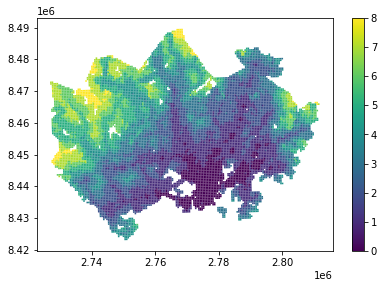

In [54]:
# Plot
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

And here we go, now we have a map where we have used one of the common classifiers to classify our data into 9 classes.

## Plotting a histogram

A histogram is a graphic representation of the distribution of the data. When classifying the data, it's always good to consider how the data is distributed, and how the classification shceme divides values into different ranges. 

- plot the histogram using [pandas.DataFrame.plot.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html)
- Number of histogram bins (groups of data) can be controlled using the parameter `bins`:

<AxesSubplot:ylabel='Frequency'>

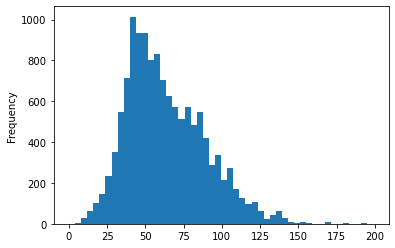

In [55]:
# Histogram for public transport rush hour travel time
acc["pt_r_tt"].plot.hist(bins=50)

Let's also add threshold values on thop of the histogram as vertical lines.

- Natural Breaks:

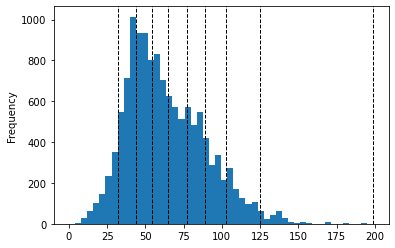

In [56]:
# Define classifier
classifier = mapclassify.NaturalBreaks(y=acc["pt_r_tt"], k=9)

# Plot histogram for public transport rush hour travel time
acc["pt_r_tt"].plot.hist(bins=50)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color="k", linestyle="dashed", linewidth=1)

- Quantiles:

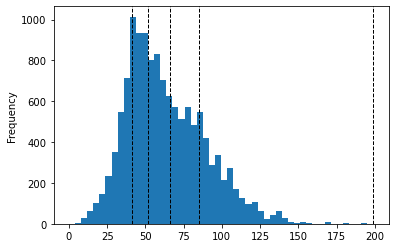

In [57]:
# Define classifier
classifier = mapclassify.Quantiles(y=acc["pt_r_tt"])

# Plot histogram for public transport rush hour travel time
acc["pt_r_tt"].plot.hist(bins=50)

for value in classifier.bins:
    plt.axvline(value, color="k", linestyle="dashed", linewidth=1)


<div class="alert alert-info">

**Check your understanding**

Select another column from the data (for example, travel times by car: `car_r_t`). Do the following visualizations using one of the classification schemes available from [pysal/mapclassify](https://github.com/pysal/mapclassify):
    
- histogram with vertical lines showing the classification bins
- thematic map using the classification scheme


</div>

## Creating a custom classifier

**Multicriteria data classification**

Let's create a function where we classify the geometries into two classes based on a given `threshold` -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a [binary classification](https://en.wikipedia.org/wiki/Binary_classification).

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

It also possible to do classifiers with multiple criteria easily in Pandas/Geopandas by extending the example that we started earlier. Now we will modify our binaryClassifier function a bit so that it classifies the data based on two columns.

- Let's call it `custom_classifier` that does the binary classification based on two treshold values:


In [58]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    """Custom classirifer that can be applied on each row of a pandas dataframe (axis=1).

    This function classifies data based on values in two source columns and stores the output value in the output column.
    Output values is 1 if the value in src_col1 is LOWER than the threshold1 value AND the value in src_col2 is HIGHER than the threshold2 value.
    In all other cases, output value is 0.

    Args:
        row: one row of data
        src_col1: source column name associated with threshold1
        src_col2: source column name associated with threshold2
        threshold1: upper threshold value for src_col1
        threshold2: lower threshold value for src_col2
        output_col: output column name

    Returns:
        updated row of data.
    """

    # If condition is true, assign 1 into output column
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        row[output_col] = 1

    # Else, assign 1 into output column
    else:
        row[output_col] = 0

    # Return the updated row
    return row

Now we have defined the function, and we can start using it.

- Let's do our classification based on two criteria and find out grid cells where the **travel time is lower or equal to 20 minutes** but they are further away **than 4 km (4000 meters) from city center**.

- Let's create an empty column for our classification results called `"suitable_area"`.


In [59]:
# Create column for the classification results
acc["suitable_area"] = None

# Use the function
acc = acc.apply(
    custom_classifier,
    src_col1="pt_r_tt",
    src_col2="walk_d",
    threshold1=20,
    threshold2=4000,
    output_col="suitable_area",
    axis=1,
)

# See the first rows
acc.head()

car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   
2    30133       50    31872       56  5785642   32940     121      146   
3    32690       54    34429       60  5785643   33233     125      150   
4    31872       42    31834       48  5787544   32127     109      126   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   
2   32940     113      133  5975375   29626     423   
3   33233     117      144  5975375   29919     427   
4   32127     101      121  5975375   31674     452   

                                            geometry  nb_pt_r_tt  \
0  POLYGON ((2767221.646 8489079.101, 2766716.966...           8   
1  POLYGON ((2767726.329 8489095.521, 2767221.646...           8   
2  POLYGON ((2768231.014 8489111.905, 2767726.329...           8   
3  POLYGON ((2768735.702 8489128.255, 2768231.014...           8   
4  POLYGON ((2765724.126 8488524.148, 2765219.488...           7   

   suitable_area  
0              0  
1              0  
2              0  
3              0  
4              0

Okey we have new values in `suitable_area` -column.

- How many Polygons are suitable for us? Let's find out by using a Pandas function called `value_counts()` that return the count of different values in our column.


In [60]:
# Get value counts
acc["suitable_area"].value_counts()

0    13011
1        9
Name: suitable_area, dtype: int64

Okay, so there seems to be nine suitable locations for us where we can try to find an appartment to buy.

- Let's see where they are located:


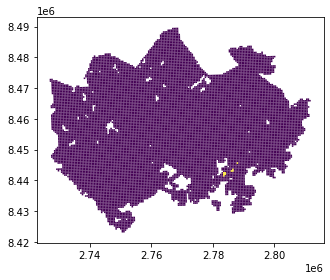

In [61]:
# Plot
acc.plot(column="suitable_area", linewidth=0)

# Use tight layour
plt.tight_layout()

A-haa, okay so we can see that suitable places for us with our criteria seem to be located in the
eastern part from the city center. Actually, those locations are along the metro line which makes them good locations in terms of travel time to city center since metro is really fast travel mode.

**Other examples**

Older course materials contain an example of applying a [custom binary classifier on the Corine land cover data](https://automating-gis-processes.github.io/2017/lessons/L4/reclassify.html#classifying-data>).